1. The sentiment dataset consists of 3000 sentences which comes from reviews from "imdb.com", "amazon.com" and "yelp.com". Each sentence is labelled according to whether it comes from a positive review or a negative review.
2. The dataset consists of 3000 sentences, each labelled '1' (if it comes from a positive review) or '-1'(if it comes from a negative review). 
3. we will use logistic regression to learn a classifier from this data.



## Load and Preprocess the data

In [40]:
import numpy as np
import warnings
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [19]:
with open("../data/full_set.txt") as f:
    content=f.readlines()

In [20]:
# remove leading and trailing whitespaces
content=[x.strip() for x in content]

In [21]:
# separate the sentences from the labels
sentences=[x.split("\t")[0] for x in content]
labels=[x.split("\t")[1] for x in content]

# transform the label from '0 versus 1' to '-1 versus 1'
y=np.array(labels, dtype='int8')
y=2*y-1

Preprocessing the text data
* to transform this prediction problem into a linear classification, we will need to preprocess the text data. we will do 4 transformation:
    * Remove punctuations and numbers
    * transform all words to lowercase
    * remove stop words
    * convert the sentences into vectors, using a bag-of-word representation

* we begin with first 2 steps

In [22]:
# Full_remove takes a string x and a list of characters "removal list" and returns with all the characters 
# in removal list replaced by " "

def full_remove(x, removal_list):
    for w in removal_list:
        x=x.replace(w, ' ')
    return x

digits=[str(x) for x in range(10)]

digit_less=[full_remove(x, digits) for x in sentences]      # remove digits
punc_less=[full_remove(x, list(string.punctuation)) for x in digit_less] # remove punctuation


sents_lower=[x.lower() for x in punc_less] # make everything lowercase
        

In [23]:
# Stop words- stop words are the words that are filtered out because they are believed to contain no useful information
# for the task at hand.
# These usually include articles such as 'a' and 'the', pronouns such as 'i' and 'they' and prepositions such as 'to' and 'from'.

stop_set=set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

# remove stop words
sents_split=[x.split() for x in sents_lower]
sents_processed=[" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

# let us look at the sentences
sents_processed[0:10]

['so there is no way for me plug in here in us unless go by converter',
 'good case excellent value',
 'great for jawbone',
 'tied charger for conversations lasting more than minutes major problems',
 'mic is great',
 'have jiggle plug get line up right get decent volume',
 'if you have several dozen or several hundred contacts then imagine fun sending each them one by one',
 'if you are razr owner you must have this',
 'needless say wasted my money',
 'what waste money and time']

## Bag of words
* In order to use the linear classifiers on our dataset, we need to transform our textual data into numeric data. The 
classical way to do this is known as "the bag of words" representation.
* In this representation, each word is thought of as corressponding to a number in "{1, 2, ....V}", where V is the size
of our vocabulary. and each sentence is represented as a 'V' dimensional vector x, where xi is the no of times that word i 
occurs in the sentence.
*To do this transformation, we will make use of the "CountVectorizer" class in scikit-learn. we will cap the no of features 
at 4500, meaning a word will make it into our vocabulary only if it is one of the 4500 most common words in the corpus. 
This is often a useful step as it can weed out spelling mistakes and words which occur too infrequently to be useful.
* finally, we will also append a '1' to the end of each vector to allow our linear classifier to learn a bias term.

In [30]:
# transform to bag of words representation
vectorizer=CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None, max_features=4500)
data_features=vectorizer.fit_transform(sents_processed)

# append 1 to the end of each vector
data_mat=data_features.toarray()

# Training/Test split : we split the data into a training set of 2500 sentences
# and a test set of 500 sentences(of which 250 are positive and 250 are negative)
# split the data into testng and training set
np.random.seed(0)
test_inds=np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds=list(set(range(len(labels)))-set(test_inds))
train_data=data_mat[train_inds,]
train_labels=y[train_inds]

test_data=data_mat[test_inds,]
test_labels=y[test_inds]

print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (2500, 4500)
Test data:  (500, 4500)


## Fitting a logistic regression model to the training data
* We could implement our own logistic regression solver using stochastic gradient descent, but fortunately, there is already one built into "scikit-learn"
* Due to the randomness in the Stochastic Gradient Descent procedure, different run can yield slightly different solutions. (and thus different error values) 

In [35]:
# Fit logistic classifier on training data
clf=SGDClassifier(loss="log", penalty="None")
clf.fit(train_data, train_labels)

# pull out the parameters (w, b) of the logistic regression models
w=clf.coef_[0, :]
b=clf.intercept_#
print("Training Error: ", float(err_train)/len(train_labels))
print("Test Error: ", float(err_test)/len(test_labels))

Training Error:  0.0032
Test Error:  0.182


## Analyse the margin
* The logistic regression model produces not just classifications but also conditional probability estimates.
* we will say that "x" has margin "gamma", if according to the logistic regression model  
"Pr(y=1|x)>(1/2)+gamma" or "Pr(y=1|x)<(1/2)-gamma". The following function margin_counts takes an input as the classifier ("clf", computed earlier), the test set("test_data"), and a value of "gamma", and computes hpw many points in the test set have margin of atleast "gamma".

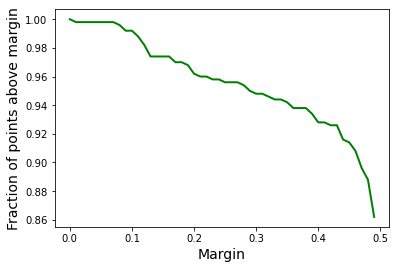

In [41]:
# return no of test points for which Pr(y=1) lies in [0, 0.5-gamma) or (0.5+gamma, 1]
def margin_counts(clf, test_data, gamma):
#     compute probability on each test point
    preds=clf.predict_proba(test_data)[:, 1]
#     find data points for which prediction is atleast gamma away from 0.5
    margin_inds=np.where((preds>(0.5+gamma)) | (preds< (0.5-gamma)))[0]
    return float(len(margin_inds))

# lets visualize the test set distribution of margin_values
gammas=np.arange(0, 0.5, 0.01)
f=np.vectorize(lambda g: margin_counts(clf, test_data, g))
plt.plot(gammas, f(gammas)/500.0, linewidth=2, color="green")
plt.xlabel("Margin", fontsize=14)
plt.ylabel("Fraction of points above margin", fontsize=14)
plt.show()
    
                                                                      

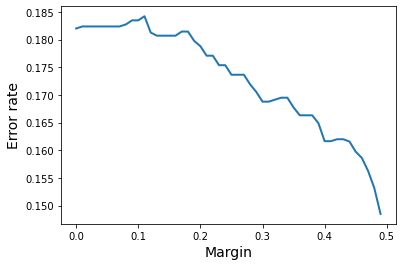

In [42]:
# We investigate the natural question: are points x  with larger margin more likely to be classified correctly?
# To identify this we define a function margin_errors that computes the fraction of points with margin atleast 
# "gamma" that are misclassified.
# Return error of predictions that lie in intervals[0, 0.5-gamma) and (0.5+gamma, 1] 

def margin_errors(clf, test_data, test_labels, gamma):
#     compute probability on each test point
    preds=clf.predict_proba(test_data)[:, 1]
#     Find data points for which prediction is at least a gamma away from 0.5
    margin_inds=np.where((preds> (0.5+gamma))|(preds<(0.5-gamma)))[0]
# Compute error on these data points
    num_errors=np.sum((preds[margin_inds]>0.5)!=(test_labels[margin_inds]>0.0))
    return float(num_errors)/len(margin_inds)
    
    
#     Let us visualize the relationship between margin and error rates.
#     Create grid of gamma values
gammas=np.arange(0, 0.5, 0.01)
# Compute margin_errors on test data for each value of g
f=np.vectorize(lambda g: margin_errors(clf, test_data, test_labels, g))

# plot the result
plt.plot(gammas, f(gammas), linewidth=2)
plt.ylabel("Error rate", fontsize=14)
plt.xlabel("Margin", fontsize=14)
plt.show()


## Words with large influence
* Finally an attempt to partially interpret the logistic regression model
* which words are most important in deciding whether a sentence is positive? As a first approximation to this, 
we simply take the words whose  coefficients in "w" have the largest possible values
* likewise, we look at the words whose coefficients in "w" have the most negative values, and we think of these 
as influential in negative prediction

In [ ]:
# convert vocabulary into a list
vocab=np.array([z[0] for z in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])])

# Get indices of sorting w
inds=np.argsort(w)

# Words with large negative values
neg_inds=inds[0:50]
print("Highly negative words: ")
print([str(x) for x in list(vocab[neg_inds])])

# words with large positive values
pos_inds=inds[-49:-1]
print("Highly positive words: ")
print()